<a href="https://colab.research.google.com/github/outfox330/ML_Models_on_Time_Series/blob/main/BTC_FORECAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 9.4 MB/s eta 0:00:00


In [2]:
pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.2 MB/s eta 0:00:00


In [ ]:
! pip install shap

In [3]:
import pandas as pd
import numpy as np

from ray import tune

In [4]:
from neuralforecast.auto import NHITS, BiTCN
from neuralforecast.core import NeuralForecast

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [5]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN, NBEATS, PatchTST
from neuralforecast.models import TSMixer, iTransformer, TimesNet
from neuralforecast.auto import MLP, AutoMLP



In [6]:
df = pd.read_csv('btc_price.csv')
df.head()

,open,high,low,close,date,daily_change
0,"64,342.23","64,489.71","62,849.56","62,880.66",8/26/24,-0.022583
1,64176.37,64996.42,63833.52,64333.54,8/25/24,0.002408
2,64103.87,64513.79,63619.92,64178.99,8/24/24,0.001321
3,60380.95,64947.06,60372.05,64094.36,8/23/24,0.061483
4,61168.32,61408.11,59815.25,60381.91,8/22/24,-0.012967


In [7]:
df_change = df[['date','daily_change']]
df_change.columns = ['ds','y']
df_change['unique_id'] = 'test'
df_change['ds'] = pd.to_datetime(df_change['ds'])
df_change

<ipython-input-7-cb823e1729fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change['unique_id'] = 'test'
<ipython-input-7-cb823e1729fc>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_change['ds'] = pd.to_datetime(df_change['ds'])
<ipython-input-7-cb823e1729fc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change['ds'] = pd.to_datetime(df_change['ds'])


,ds,y,unique_id
0,2024-08-26,-0.022583,test
1,2024-08-25,0.002408,test
2,2024-08-24,0.001321,test
3,2024-08-23,0.061483,test
4,2024-08-22,-0.012967,test
...,...,...,...
1373,2020-11-22,-0.014603,test
1374,2020-11-21,0.001123,test
1375,2020-11-20,0.045138,test
1376,2020-11-19,0.000735,test


In [8]:
df_change = df_change.dropna(axis=0)
df_change

,ds,y,unique_id
0,2024-08-26,-0.022583,test
1,2024-08-25,0.002408,test
2,2024-08-24,0.001321,test
3,2024-08-23,0.061483,test
4,2024-08-22,-0.012967,test
...,...,...,...
1372,2020-11-23,-0.000320,test
1373,2020-11-22,-0.014603,test
1374,2020-11-21,0.001123,test
1375,2020-11-20,0.045138,test


In [9]:
horizon =2
models = [NBEATS(input_size=15,h=horizon, max_steps=200, enable_checkpointing=True),
         NHITS(input_size=15,h=horizon, max_steps=200, enable_checkpointing=True),
          AutoMLP(config=dict(max_steps=200,
                              input_size=tune.choice([24]),
                              learning_rate=tune.choice([1e-3])),
                  h=horizon, num_samples=1),
          TSMixer(h=horizon, input_size=15, n_series=1, max_steps=200),
          iTransformer(h=horizon, input_size=15, n_series=1, max_steps=200),
          PatchTST(h=horizon, input_size=15, max_steps=200),
          TimesNet(h=horizon, input_size=15, max_steps=200)]

nf = NeuralForecast(models=models, freq='D')
nf.fit(df=df_change)
Y_hat_df = nf.predict().reset_index()
Y_hat_df

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-27 00:39:29,372	INFO worker.py:1781 -- Started a local Ray instance.
2024-08-27 00:39:31,700	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-08-27_00-39-26   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 1                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-08-27_00-39-26
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-08-27_00-39-26_237659_1092/artifacts/2024-08-27_00-39-31/_train_tune_2024-08-27_00-39-26/driver_artifacts`


(_train_tune pid=2373) /usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=2373)   return torch.load(i

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.021, train_loss_epoch=0.021]


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, v_num=0, train_loss_step=0.0215, train_loss_epoch=0.021]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 197:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0181, train_loss_epoch=0.0181, valid_loss=0.0212]


2024-08-27 00:40:19,041	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-08-27_00-39-26' in 0.0065s.


Epoch 199:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0191, train_loss_epoch=0.0191, valid_loss=0.0212]


(_train_tune pid=2373) `Trainer.fit` stopped: `max_steps=200` reached.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s, v_num=0, train_loss_step=0.0173, train_loss_epoch=0.0191, valid_loss=0.0212]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s, v_num=0, train_loss_step=0.0173, train_loss_epoch=0.0173, valid_loss=0.0291]



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,NBEATS,NHITS,AutoMLP,TSMixer,iTransformer,PatchTST,TimesNet
0,test,2024-08-27,0.002391,0.001820,0.000675,-0.000256,0.004279,0.007691,0.001042
1,test,2024-08-28,0.000108,-0.000811,-0.001025,0.003949,0.003125,0.004376,0.001623


In [13]:
Y_hat_df.to_csv('daily_change_output.csv')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

# New Section

In [18]:
df1 = pd.read_csv('bitcoin.csv')
df1.head()

,close,date
0,62880.65865,8/26/24
1,64333.54418,8/25/24
2,64178.99065,8/24/24
3,64094.35721,8/23/24
4,60381.91246,8/22/24


In [20]:
df2 = pd.read_csv('bnb.csv')
df2.head()

,close,date
0,548.828031,8/26/24
1,574.249965,8/25/24
2,580.762177,8/24/24
3,591.806050,8/23/24
4,583.051855,8/22/24


In [21]:
df3 = pd.read_csv('dogecoin.csv')
df3.head()

,close,date
0,0.105292,8/26/24
1,0.109698,8/25/24
2,0.112631,8/24/24
3,0.112927,8/23/24
4,0.105308,8/22/24


In [22]:
df4 = pd.read_csv('eth.csv')
df4.head()

,close,date
0,2681.340514,8/26/24
1,2749.157667,8/25/24
2,2769.389732,8/24/24
3,2764.447103,8/23/24
4,2622.951355,8/22/24


In [23]:
df5 = pd.read_csv('solana.csv')
df5.head()

,close,date
0,157.236879,8/26/24
1,158.909125,8/25/24
2,160.731744,8/24/24
3,153.107085,8/23/24
4,143.257930,8/22/24


In [25]:
df_total = df1
df_total = df_total[['date','close']]
df_total.columns = ['date','bitcoin']
df_total

,date,bitcoin
0,8/26/24,62880.65865
1,8/25/24,64333.54418
2,8/24/24,64178.99065
3,8/23/24,64094.35721
4,8/22/24,60381.91246
...,...,...
951,1/18/22,42375.63284
952,1/17/22,42250.54937
953,1/16/22,43113.88011
954,1/15/22,43177.39679


In [26]:
df_total['bnb'] = df2['close']
df_total['dogecoin'] = df3['close']
df_total['eth'] = df4['close']
df_total['solana'] = df5['close']
df_total

<ipython-input-26-0327495d5424>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['bnb'] = df2['close']
<ipython-input-26-0327495d5424>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['dogecoin'] = df3['close']
<ipython-input-26-0327495d5424>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

,date,bitcoin,bnb,dogecoin,eth,solana
0,8/26/24,62880.65865,548.828031,0.105292,2681.340514,157.236879
1,8/25/24,64333.54418,574.249965,0.109698,2749.157667,158.909125
2,8/24/24,64178.99065,580.762177,0.112631,2769.389732,160.731744
3,8/23/24,64094.35721,591.806050,0.112927,2764.447103,153.107085
4,8/22/24,60381.91246,583.051855,0.105308,2622.951355,143.257930
...,...,...,...,...,...,...
951,1/18/22,42375.63284,472.005051,0.165485,3164.025254,141.587192
952,1/17/22,42250.54937,475.709867,0.171145,3212.304897,139.926008
953,1/16/22,43113.88011,498.427925,0.177176,3350.921969,147.856514
954,1/15/22,43177.39679,494.988068,0.185103,3330.530846,147.801178


In [28]:
df_total['date'] = pd.to_datetime(df_total['date'])

<ipython-input-28-8e756b067241>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_total['date'] = pd.to_datetime(df_total['date'])
<ipython-input-28-8e756b067241>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['date'] = pd.to_datetime(df_total['date'])


In [29]:
df_total = df_total.sort_values('date')
df_total

,date,bitcoin,bnb,dogecoin,eth,solana
955,2022-01-14,43099.69983,489.867424,0.183549,3310.001423,146.159033
954,2022-01-15,43177.39679,494.988068,0.185103,3330.530846,147.801178
953,2022-01-16,43113.88011,498.427925,0.177176,3350.921969,147.856514
952,2022-01-17,42250.54937,475.709867,0.171145,3212.304897,139.926008
951,2022-01-18,42375.63284,472.005051,0.165485,3164.025254,141.587192
...,...,...,...,...,...,...
4,2024-08-22,60381.91246,583.051855,0.105308,2622.951355,143.257930
3,2024-08-23,64094.35721,591.806050,0.112927,2764.447103,153.107085
2,2024-08-24,64178.99065,580.762177,0.112631,2769.389732,160.731744
1,2024-08-25,64333.54418,574.249965,0.109698,2749.157667,158.909125


In [30]:
df_total['bitcoin_return'] = df_total['bitcoin'].pct_change()
df_total['bnb_return'] = df_total['bnb'].pct_change()
df_total['dogecoin_return'] = df_total['dogecoin'].pct_change()
df_total['eth_return'] = df_total['eth'].pct_change()
df_total['solana_return'] = df_total['solana'].pct_change()

df_total



,date,bitcoin,bnb,dogecoin,eth,solana,bitcoin_return,bnb_return,dogecoin_return,eth_return,solana_return
955,2022-01-14,43099.69983,489.867424,0.183549,3310.001423,146.159033,NaN,NaN,NaN,NaN,NaN
954,2022-01-15,43177.39679,494.988068,0.185103,3330.530846,147.801178,0.001803,0.010453,0.008466,0.006202,0.011235
953,2022-01-16,43113.88011,498.427925,0.177176,3350.921969,147.856514,-0.001471,0.006949,-0.042825,0.006122,0.000374
952,2022-01-17,42250.54937,475.709867,0.171145,3212.304897,139.926008,-0.020024,-0.045579,-0.034035,-0.041367,-0.053636
951,2022-01-18,42375.63284,472.005051,0.165485,3164.025254,141.587192,0.002961,-0.007788,-0.033073,-0.015030,0.011872
...,...,...,...,...,...,...,...,...,...,...,...
4,2024-08-22,60381.91246,583.051855,0.105308,2622.951355,143.257930,-0.012967,0.022863,-0.007995,-0.003209,0.003842
3,2024-08-23,64094.35721,591.806050,0.112927,2764.447103,153.107085,0.061483,0.015014,0.072353,0.053945,0.068751
2,2024-08-24,64178.99065,580.762177,0.112631,2769.389732,160.731744,0.001320,-0.018661,-0.002625,0.001788,0.049800
1,2024-08-25,64333.54418,574.249965,0.109698,2749.157667,158.909125,0.002408,-0.011213,-0.026038,-0.007306,-0.011340


In [31]:
df_total = df_total.dropna(axis=0)
df_total

,date,bitcoin,bnb,dogecoin,eth,solana,bitcoin_return,bnb_return,dogecoin_return,eth_return,solana_return
954,2022-01-15,43177.39679,494.988068,0.185103,3330.530846,147.801178,0.001803,0.010453,0.008466,0.006202,0.011235
953,2022-01-16,43113.88011,498.427925,0.177176,3350.921969,147.856514,-0.001471,0.006949,-0.042825,0.006122,0.000374
952,2022-01-17,42250.54937,475.709867,0.171145,3212.304897,139.926008,-0.020024,-0.045579,-0.034035,-0.041367,-0.053636
951,2022-01-18,42375.63284,472.005051,0.165485,3164.025254,141.587192,0.002961,-0.007788,-0.033073,-0.015030,0.011872
950,2022-01-19,41744.32984,462.822096,0.162356,3095.825838,135.792388,-0.014898,-0.019455,-0.018912,-0.021555,-0.040927
...,...,...,...,...,...,...,...,...,...,...,...
4,2024-08-22,60381.91246,583.051855,0.105308,2622.951355,143.257930,-0.012967,0.022863,-0.007995,-0.003209,0.003842
3,2024-08-23,64094.35721,591.806050,0.112927,2764.447103,153.107085,0.061483,0.015014,0.072353,0.053945,0.068751
2,2024-08-24,64178.99065,580.762177,0.112631,2769.389732,160.731744,0.001320,-0.018661,-0.002625,0.001788,0.049800
1,2024-08-25,64333.54418,574.249965,0.109698,2749.157667,158.909125,0.002408,-0.011213,-0.026038,-0.007306,-0.011340


In [32]:
import statsmodels.api as sm

y = df_total['bitcoin_return']

X = df_total[['bnb_return','dogecoin_return', 'eth_return', 'solana_return']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         bitcoin_return   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     837.1
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          1.46e-309
Time:                        02:46:50   Log-Likelihood:                 2750.6
No. Observations:                 955   AIC:                            -5491.
Df Residuals:                     950   BIC:                            -5467.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000     

In [42]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', max_depth=10)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)




In [43]:
rmse = mean_squared_error(y_test, preds, squared=False)
rmse

0.016215290087168627

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

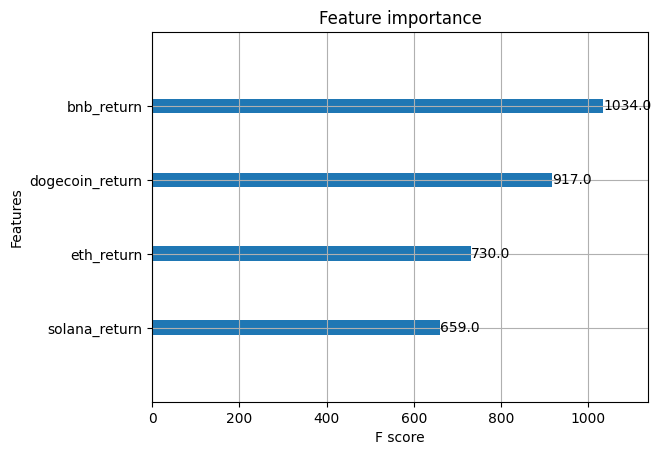

In [44]:
xgb.plot_importance(xg_reg)

<Axes: >

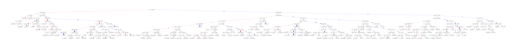

In [45]:
from xgboost import plot_tree
plot_tree(xg_reg._Booster)

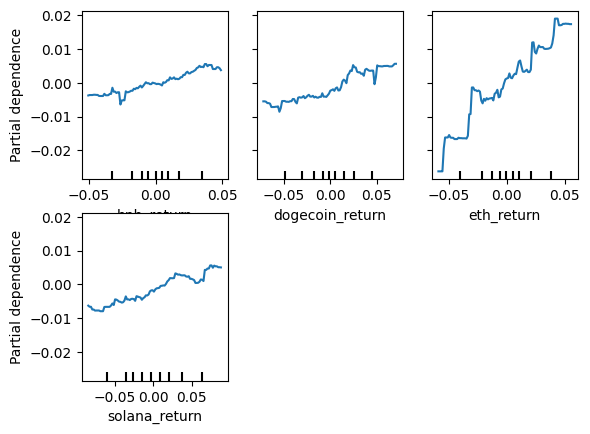

In [51]:
# from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = ['bnb_return','dogecoin_return', 'eth_return', 'solana_return']

PartialDependenceDisplay.from_estimator(xg_reg, X_train,
                                                [1, 2,3,4])


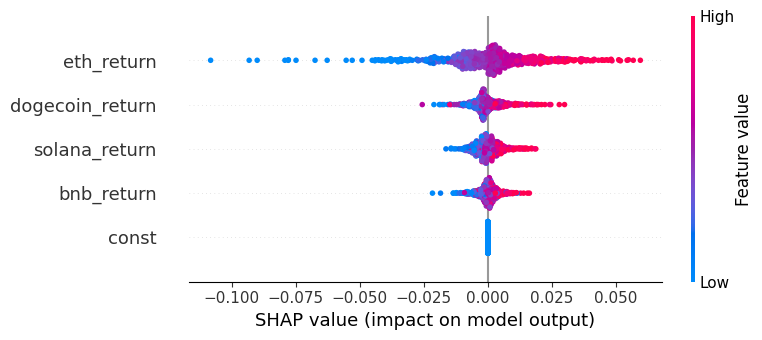

In [54]:
import shap

explainer = shap.Explainer(xg_reg)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)